# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset

2021-11-07 13:27:38.725859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-07 13:27:38.725897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
dataset = get_dataset("./data/waymo/processed/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 3
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [4]:
print(list(dataset.take(1).as_numpy_iterator()))

2021-11-07 13:28:03.343712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[{'image': array([[[156, 203, 245],
        [158, 205, 247],
        [166, 213, 255],
        ...,
        [ 50,  68,  78],
        [ 51,  69,  79],
        [ 52,  70,  80]],

       [[160, 207, 249],
        [159, 206, 248],
        [160, 207, 249],
        ...,
        [ 52,  70,  80],
        [ 50,  68,  78],
        [ 49,  67,  77]],

       [[161, 208, 250],
        [161, 208, 250],
        [163, 208, 250],
        ...,
        [ 53,  70,  80],
        [ 50,  68,  78],
        [ 49,  67,  77]],

       ...,

       [[ 64,  82,  86],
        [ 65,  83,  87],
        [ 66,  83,  90],
        ...,
        [ 45,  69,  79],
        [ 45,  68,  76],
        [ 46,  66,  75]],

       [[ 65,  80,  85],
        [ 67,  82,  87],
        [ 68,  85,  92],
        ...,
        [ 50,  74,  84],
        [ 52,  74,  85],
        [ 52,  72,  83]],

       [[ 67,  82,  87],
        [ 71,  86,  91],
        [ 69,  86,  93],
        ...,
        [ 47,  71,  81],
        [ 49,  71,  82],
        [ 48,

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [97]:
LABEL_TO_CLASS = { 
    1: { 
            'name': 'vehicle',
            'color': 'red'
    },
    2: {
            'name': 'pedestrian',
            'color': 'cyan'
    },
    4: {
            'name': 'cyclist',
            'color': 'blue'
    }
}

LABELS = LABEL_TO_CLASS.keys()

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib notebook

def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """      
    def draw_an_image(record):
        try:
            image = record["image"].numpy()
            # print(image.shape) 640 * 640 * 3
            height, width, _ = image.shape
            
            # original waymo data set 1920 * 1280
            # bounding box 640 * 640
            X_SCALE_FACTOR = 1# 640 / 1920
            Y_SCALE_FACTOR = 1# 640 / 1280
            
            scaled_width = width * X_SCALE_FACTOR
            scaled_height = height * Y_SCALE_FACTOR
            
            groundtruth_boxes = record["groundtruth_boxes"].numpy()
            groundtruth_classes = record["groundtruth_classes"].numpy()
                    
            fig, ax = plt.subplots(1, figsize=(5,5))

            ax.imshow(image.astype(np.uint8))

            for box, label in zip( groundtruth_boxes, groundtruth_classes ):
                y1, x1, y2, x2 = box

                left_bottom = (x1 * scaled_width, y1 * scaled_height)
                
                box_width = (x2 - x1) * scaled_width
                box_height = (y2 - y1) * scaled_height
                
                rec = Rectangle(left_bottom, box_width, box_height, linewidth=1, edgecolor=LABEL_TO_CLASS[label]['color'], facecolor='none')
                
                ax.add_patch(rec)

            ax.axis("off")
        except Exception as err:
            print(err)
    
    #plt.figure(figsize=(10,10))
    
    for record in batch:
        draw_an_image(record)

    plt.show()
    

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

<IPython.core.display.Javascript object>


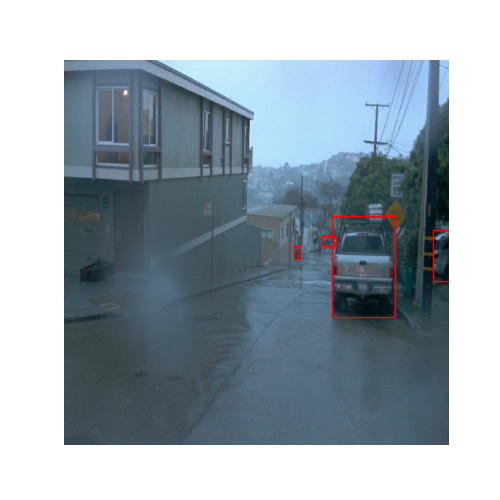

<IPython.core.display.Javascript object>


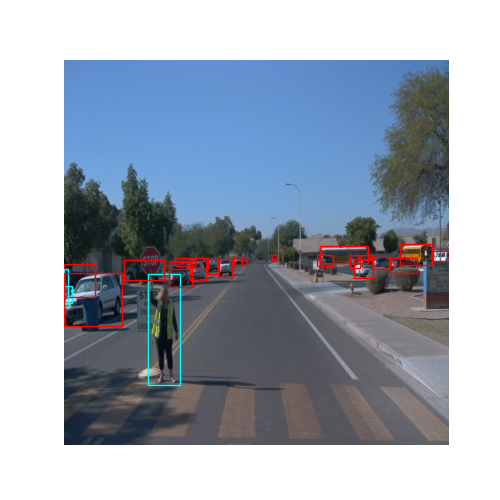

<IPython.core.display.Javascript object>


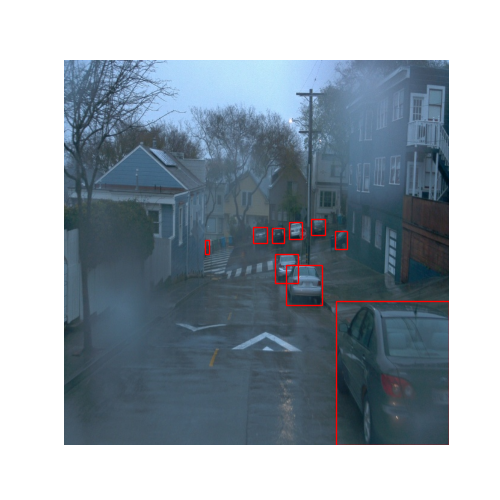

<IPython.core.display.Javascript object>


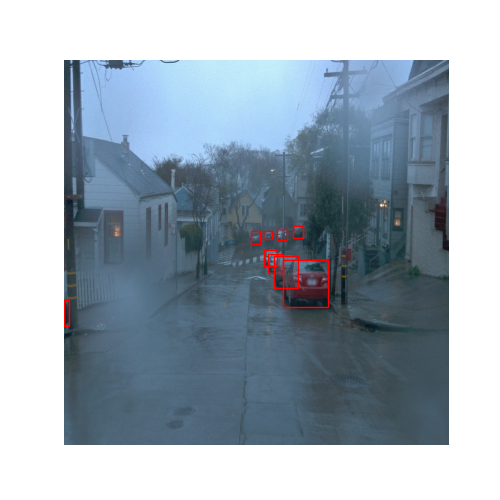

<IPython.core.display.Javascript object>


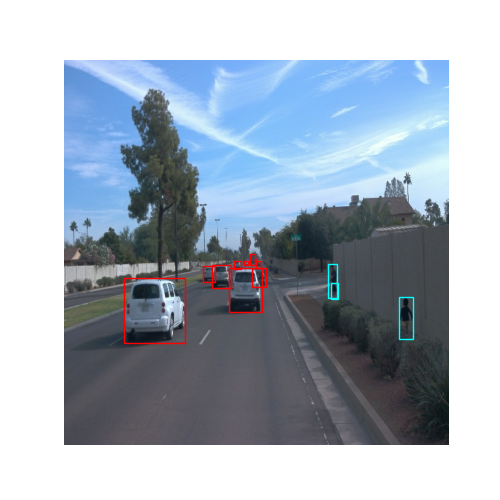

<IPython.core.display.Javascript object>


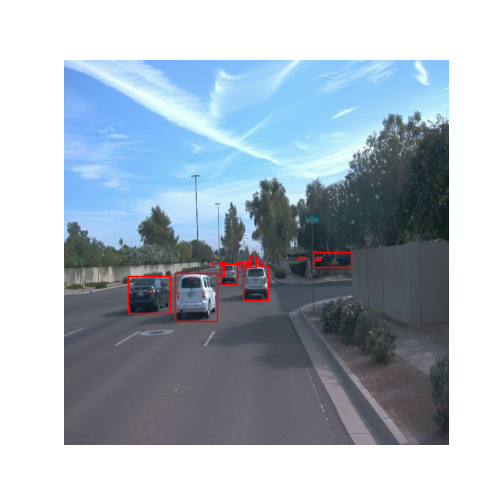

<IPython.core.display.Javascript object>


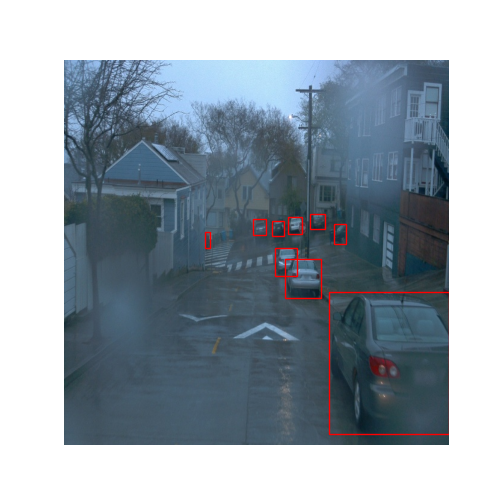

<IPython.core.display.Javascript object>


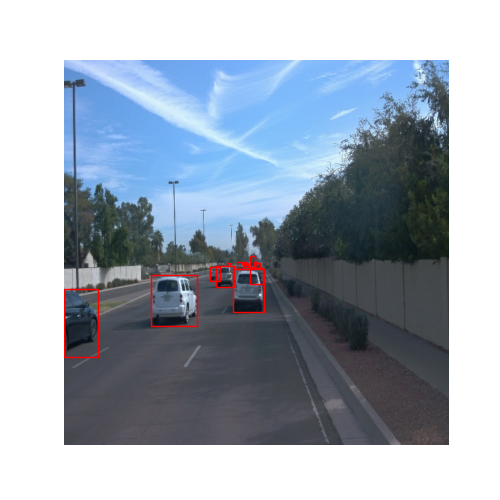

<IPython.core.display.Javascript object>


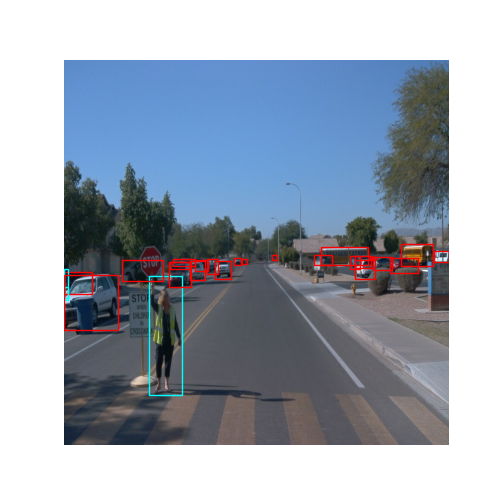

<IPython.core.display.Javascript object>


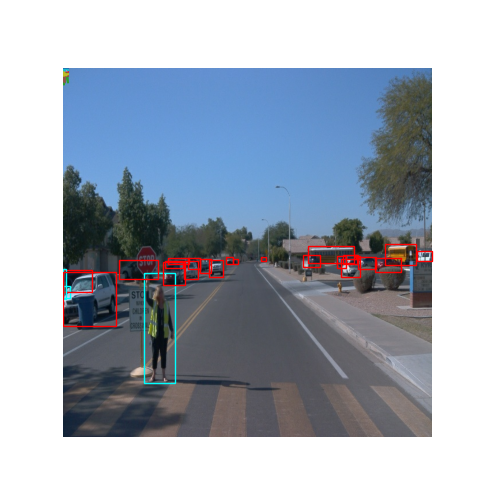

In [22]:
ten_records = dataset.shuffle(50).take(10)
display_instances(ten_records)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [261]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib notebook

def print_stats(paths_tfrecord):
    # https://www.tensorflow.org/tutorials/load_data/tfrecord
    # https://www.tensorflow.org/tutorials/load_data/tfrecord#tftrainexample
    # https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb
    records_stat = [] # [ { record_name: "segment-1", classes : { 1: { counts: 1, sum_size: 0.1 } } } ]
    
    raw_dataset = tf.data.TFRecordDataset(paths_tfrecord)

    for raw_record in raw_dataset:
        example = tf.train.Example()    
        example.ParseFromString(raw_record.numpy())

        # keys in example.features.feature
        # image/height
        # image/format
        # image/object/bbox/xmax
        # image/object/class/label
        # image/object/bbox/ymin
        # image/width
        # image/object/bbox/xmin
        # image/filename
        # image/object/bbox/ymax
        # image/source_id
        # image/object/class/text
        # image/encoded

        # only one filename for each record
        filename = example.features.feature['image/filename'].bytes_list.value[0].decode('utf-8')
        list_xmax = np.array(example.features.feature['image/object/bbox/xmax'].float_list.value)
        list_xmin = np.array(example.features.feature['image/object/bbox/xmin'].float_list.value)
        list_ymax = np.array(example.features.feature['image/object/bbox/ymax'].float_list.value)
        list_ymin = np.array(example.features.feature['image/object/bbox/ymin'].float_list.value)
        list_label = np.array(example.features.feature['image/object/class/label'].int64_list.value)
        list_size = (list_xmax - list_xmin) * (list_ymax - list_ymin)
        
        stat = {
            'record_name': filename,
            'classes': {}
        }
        
        for label in LABELS:
            filter = [ label == raw_label for raw_label in list_label ]
            filtered = list_size[filter]
            avg = np.average(filtered)
            stat['classes'][label] = { 'counts': len(filtered), 'avg_size': avg }

        records_stat.append(stat)
    
    fig, ax = plt.subplots(2, figsize=(5,5))
    fig.suptitle('Class stats')
    
    for label in LABELS:
        label_counts = [stat['classes'][label]['counts'] for stat in records_stat]
        ax[0].plot(np.arange(len(records_stat)), np.array(label_counts))
        
        
    ax[0].set(xlabel='Record #', ylabel='Counts')
    ax[0].set_title('Counts of classes')
    ax[0].legend(['vehicles', 'pedestrain', 'cyclist'])
    
    for label in LABELS:
        label_counts = [stat['classes'][label]['avg_size'] for stat in records_stat]
        ax[1].plot(np.arange(len(records_stat)), np.array(label_counts))
        
        
    ax[1].set(xlabel='Record #', ylabel='Avg. Size of Bounding boxes')
    ax[1].set_title('Avg. size of bounding boxes of classes')
    ax[1].legend(['vehicles', 'pedestrain', 'cyclist'])
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    for record_num in range(0, len(records_stat)):
        print('Record #', record_num, records_stat[record_num]['record_name'])
        


/home/sijoonlee/Documents/self-driving-course/environment/course_env/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/sijoonlee/Documents/self-driving-course/environment/course_env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


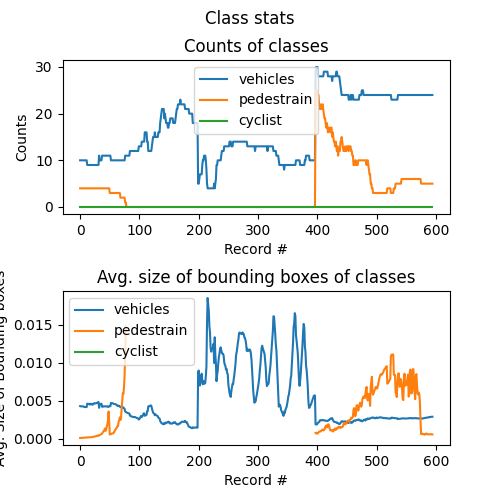

Record # 0 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_0.tfrecord
Record # 1 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_1.tfrecord
Record # 2 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_2.tfrecord
Record # 3 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_3.tfrecord
Record # 4 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_4.tfrecord
Record # 5 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_5.tfrecord
Record # 6 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_6.tfrecord
Record # 7 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_7.tfrecord
Record # 8 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_8.tfrecord
Record # 9 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_9.tfrecord
Record # 10 segment-1005081002024129653_5313_150_5333_150_with_camera_labels_10.tfrecord
Record # 11 segment-1005081002024129653_5

Record # 398 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_1.tfrecord
Record # 399 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_2.tfrecord
Record # 400 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_3.tfrecord
Record # 401 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_4.tfrecord
Record # 402 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_5.tfrecord
Record # 403 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_6.tfrecord
Record # 404 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_7.tfrecord
Record # 405 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_8.tfrecord
Record # 406 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_9.tfrecord
Record # 407 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_10.tfrecord
Record # 408 segment-1022527355599519580_4866_960_4886_960_with_camera_labels_11.tfrecord
Record # 409 segmen

In [262]:
import glob, os
tf_records_paths = glob.glob("./data/waymo/processed/*.tfrecord")
print_stats(tf_records_paths)